In [1]:
# import modules
import random
import numpy
import pandas
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import os
cwd = os.getcwd()
import statsmodels.stats.moment_helpers
from datetime import datetime
import multiprocessing as mp
import csv
import networkx as nx


# Test out a network structure by uncommenting a section 1-4 below (default fully-connected)

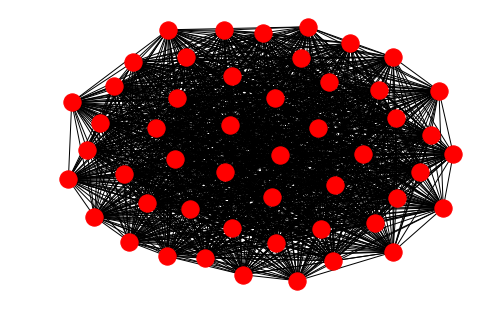

In [6]:
## 1 - full-connected
net=nx.complete_graph(50)

## 2 - connected caveman
#net = nx.connected_caveman_graph(5,10)

## 3 - small world
#net= nx.watts_strogatz_graph(50, 10, .1, seed=None)

## 4 - realistic social network
# net = pandas.read_csv(str(cwd)+'/real_world_nets/real_world_net_'+str(1) +'.csv')
# del net['Unnamed: 0']
# net.columns=(range(50))
# net=nx.convert_matrix.from_pandas_adjacency(net)

# visualize your network
nx.draw(net)


Get some common measures for this network:

In [7]:
print('Clustering Coefficient')
sum(nx.clustering(net).values())/50

Clustering Coefficient


1.0

In [8]:
print('Average shortest path length')
nx.average_shortest_path_length(net)

Average shortest path length


1.0

In [9]:
print('Mean degree')
sum(numpy.array(nx.degree(net))[:,1])/50

Mean degree


49.0

# Model Functions

Bayesian updating functions

In [10]:
def G(x,y,xmean,ymean,xsd,ysd,corr):
    return ( (1/(2*numpy.pi*xsd*ysd*numpy.sqrt((1-corr**2))))  * numpy.exp( -(1/(2*(1-corr**2))) * ( (((x-xmean)**2)/(xsd)**2) - ((2*corr*(x-xmean)*(y-ymean))/(xsd*ysd)) + (((y-ymean)**2)/(ysd**2)) )))
    
def d_freq(posterior,age):
    return learning_rate_freq * posterior

def d_xmean(x,y,xmean,ymean,xsd,ysd,corr,posterior,age):
    return learning_rate_mean * posterior * ( 1/(1-corr**2) ) * ( ((x-xmean)/xsd**2) - (corr*y)/(xsd*ysd) ) #* (1-(y/100))

def d_xsd(x,y,xmean,ymean,xsd,ysd,corr,posterior,age):
    return learning_rate_sd * posterior * ( ((x-xmean)**2)/((xsd**3)*(1-corr**2)) - ((corr*(x-xmean)*(y-ymean))/((xsd**2)*ysd*(1-corr**2))) - (1/xsd) )

def d_ymean(x,y,xmean,ymean,xsd,ysd,corr,posterior,age):
    return learning_rate_mean * posterior * ( 1/(1-corr**2) ) * ( ((y-ymean)/ysd**2) - (corr*x)/(ysd*xsd) ) #* (1-(y/100))

def d_ysd(x,y,xmean,ymean,xsd,ysd,corr,posterior,age):
    return learning_rate_sd * posterior * ( ((y-ymean)**2)/((ysd**3)*(1-corr**2)) - ((corr*(y-ymean)*(x-xmean))/((ysd**2)*xsd*(1-corr**2))) - (1/ysd) )

#note that we currently do not let the correlations between dimensions update; they are fixed at 0
def d_corr(x,y,xmean,ymean,xsd,ysd,corr,posterior,age,crit):
    #next line is what appears to actually have been used in code of Toscano & McMurray 2010 -- not sure which is correct (difference is the corr**3 vs corr in second term)
    #return learning_rate_corr/(1+crit*age) * posterior * ( (1/(1-corr**2)) *  ( corr -  (1/(1-corr**2)) * ( (corr*(x-xmean)**2)/(xsd**2) - ( ((corr**2)+1)*(x-xmean)*(y-ymean)) / (xsd*ysd)  + ((corr*(y-ymean**2))/(ysd**2)) ) ))
    
    #next line is what is reported in Toscano & McMurray 2010
    return  learning_rate_corr * posterior * (1/(1-corr**2)) *  ( corr**3 -  (1/(1-corr**2)) * ( (corr*(x-xmean)**2)/(xsd**2) - ( ((corr**2)+1)*(x-xmean)*(y-ymean)) / (xsd*ysd)  + ((corr*(y-ymean**2))/(ysd**2)) ) )

Function for plotting global attractor landscape

In [11]:
def make_movie(agents,iteration, fname):
    df=pandas.DataFrame([])
    for i in range(len(agents)):
        cur_data=agents[i]
        temp=pandas.DataFrame(list(zip(cur_data.xmeans,cur_data.xsds,cur_data.ymeans,cur_data.ysds,cur_data.freqs/sum(cur_data.freqs),[i]*len(cur_data.labels))),columns=['xmean','xsd','ymean','ysd','freq','agent'])
        if i==0:
            df=temp
        else:
            df=df.append(temp,ignore_index=True)

    colourCount=len(numpy.unique(df.agent))
    cmap = matplotlib.cm.get_cmap('Paired', colourCount)
    colors=numpy.empty([0,4])
    for i in range(len(df)):
        colors=numpy.vstack([colors,cmap.colors[df['agent'][i],:]])
    alphas=df['freq']
    #if iteration==0:
    #    alphas=1-(max(alphas)-alphas)
    #else:
    #    alphas=(alphas-min(alphas))/(max(alphas)-min(alphas))*(1-.4)+.4
    colors[:,3]=alphas
    
    plt.close()
    fig= plt.figure(figsize=(10,10))
    plt.style.use('dark_background')
    plt.scatter(df['xmean'], df['ymean'], color=colors,s=df['xsd']*500)
    #plt.scatter(df['xmean'], df['ymean'], color=colors)
    plt.yscale('linear')
    plt.xticks(numpy.arange(0, 101, 10))
    plt.yticks(numpy.arange(0, 101, 10))
    plt.minorticks_on()
    plt.grid(True,which='major', color='#606060')
    plt.axis('square')
    plt.axis([0,100,0,100])
    plt.title('T = %s' %(iteration))
    plt.xlabel('Feature X Value')
    plt.ylabel('Feature Y Value')
    plt.savefig(fname)
    #plt.show()

Agent functions

In [12]:
class agent():
    
    def __init__(self,K,sd_init,age):
        
        self.xmeans=numpy.array(numpy.random.rand(K)*100) # K random means in 100 X 100 space for the x dimension
        self.xsds=numpy.full(K,sd_init) # the initial SD of each gaussian in an agent's MOG in x dimension
        self.ymeans=numpy.array(numpy.random.rand(K)*100) # K random means in 100 X 100 space for the y dimension
        self.ysds=numpy.full(K,sd_init) # the initial SD of each gaussian in an agent's MOG in y dimension
        self.freqs=numpy.full(K,(1/K)) # gaussians in an agent's MOG start out with uniform initial frequency
        self.corrs=numpy.full(K,0,dtype=numpy.float128) # set the correlations to 0
        self.labels=numpy.array(list(range(0,K)))
        
        self.likelihoods=numpy.array([])
        self.posteriors=numpy.array([])
        self.age=age
     
    ######
    
    def russian_roulette(self, doff, dead_agents, cur_agent): # decide whether the agent dies on this iteration
        
        if numpy.random.uniform(0,1) < (1/doff):
            dead_agents.append(cur_agent)
            
        return dead_agents
    
    ######
    
    def utter(self, attraction, transmission_error): # selects a gaussian from the agent's MOG to communicate, based on the frequency of each Gaussian
        
        ps=self.freqs/sum(self.freqs)
        label=numpy.random.choice(self.labels,1,p=ps)[0]
        
        x_val=numpy.random.normal(self.xmeans[label],self.xsds[label]*(1-attraction)+transmission_error) # generate the x-dimension of the signal, based on the mean and SD, then apply prototype bias and transmission noise
        if x_val<0:
            x_val=0
        elif x_val>100:
            x_val=100
        
        y_val=numpy.random.normal(self.ymeans[label],self.ysds[label]*(1-attraction)+transmission_error) # generate the y-dimension of the signal, based on the mean and SD, then apply prototype bias and transmission noise
        if y_val<0:
            y_val=0
        elif y_val>100:
            y_val=100
        utterance=[x_val,y_val]
        
        return utterance
            
    ######

    def listen_learn(self, utterance, crit, errors): # function for a signal receiver to categorize the token and update their MOG
        
        length=len(self.labels)

        # compute the likelihood of the current utterance belonging to each Gaussian in the listener's MOG
        self.Gs=numpy.array([G(utterance[0],utterance[1],self.xmeans[i],self.ymeans[i],self.xsds[i],self.ysds[i],self.corrs[i]) for i in range(length)])

        self.likelihoods=self.Gs*self.freqs

        divisor=sum(self.likelihoods)
        if divisor==0:
            print('divisor is 0')

        # posterior probability of each Gaussian is just the normalized likelihood
        self.posteriors=self.likelihoods/divisor

        # select the Gaussian with the highest posterior probability. 
        try:
            arg_max=numpy.where(self.posteriors == numpy.amax(self.posteriors))[0][0]
        except:
            print('utterance = ')
            print(utterance[0],utterance[1])
            print('repertoire = ')
            for i in self.labels:
                print(self.xmeans[i],self.ymeans[i],self.xsds[i],self.ysds[i],self.corrs[i],self.likelihoods[i])

        x=self.xmeans[arg_max]
        y=self.ymeans[arg_max]
        
        # we can get an error term, the euclidean distance between the signal and the mean of the Gaussian selected
        error=numpy.sqrt((utterance[0]-x)**2+(utterance[1]-y)**2)
        errors.append(error)
            
        if self.age <= crit: # agents do not update their MOG if they are older than the critical period
            
            # this chunk gets the delta values: the change in each parameter
            d_xmeans=numpy.array([d_xmean(utterance[0],utterance[1],self.xmeans[i],self.ymeans[i],self.xsds[i],self.ysds[i],self.corrs[i],self.posteriors[i],self.age) for i in range(length)])
            d_ymeans=numpy.array([d_ymean(utterance[0],utterance[1],self.xmeans[i],self.ymeans[i],self.xsds[i],self.ysds[i],self.corrs[i],self.posteriors[i],self.age) for i in range(length)])
            d_xsds=numpy.array([d_xsd(utterance[0],utterance[1],self.xmeans[i],self.ymeans[i],self.xsds[i],self.ysds[i],self.corrs[i],self.posteriors[i],self.age) for i in range(length)])
            d_ysds=numpy.array([d_ysd(utterance[0],utterance[1],self.xmeans[i],self.ymeans[i],self.xsds[i],self.ysds[i],self.corrs[i],self.posteriors[i],self.age) for i in range(length)])
            #d_corrs=numpy.array([d_corr(utterance[0],utterance[1],self.xmeans[i],self.ymeans[i],self.xsds[i],self.ysds[i],self.corrs[i],self.posteriors[i],self.age) for i in range(length)])
            
            # we then apply the changes, while making sure the values stay within bounds
            self.xmeans=self.xmeans+d_xmeans
            self.xmeans=[0 if ele<0 else ele for ele in self.xmeans]
            self.xmeans=[100 if ele>100 else ele for ele in self.xmeans]

            self.xsds=self.xsds+d_xsds
            self.xsds=[1 if ele<1 else ele for ele in self.xsds]

            self.ymeans=self.ymeans+d_ymeans
            self.ymeans=[0 if ele<0 else ele for ele in self.ymeans]
            self.ymeans=[100 if ele>100 else ele for ele in self.ymeans]

            self.ysds=self.ysds+d_ysds
            self.ysds=[1 if ele<1 else ele for ele in self.ysds]

            #self.corrs=self.corrs+learning_rate_corr*(1-numpy.sqrt(numpy.array(self.corrs)**2))*(-2/(1+numpy.exp(d_corrs))+1)
         
            # only the Gaussian with the highest posterior probability increases in frequency
            self.freqs[arg_max]=self.freqs[arg_max]+d_freq(self.posteriors[arg_max],self.age)
            # the frequencies are then normalized to sum to 1
            self.freqs=self.freqs/sum(self.freqs)
            
        return errors


Functions for running the model

In [15]:
################

def initialize_agentset(pop_size_init,K,sd_init,load_agents,doff):
    print("initializing...")
    
    if load_agents==1: # in some cases we may wish to load a model from a previous state, but not used currently. 
        agents=numpy.load(load_path,allow_pickle=True).tolist()
    else:
        agents=[]
        for a in range(pop_size_init): 
#             for i in range(40000):
#                 if numpy.random.uniform(0,1) < (1/doff):
#                     age=i
#                     break
            agents.append(agent(K,sd_init,0)) # currently all agents start at age 0; can uncomment above or change it to get a different distribution of initial ages
            
    return agents
            
########
            
def death_birth(agents, dead_agents, accum_birth, cur_pop, end_pop, K, sd_init, growth_rate): # Currently we just replace every dead agent with a new one. We can set a growth rate or add a reproduction stage to make this more realistic
    
    if len(dead_agents) > 0:
        for i in sorted(dead_agents, reverse=True):
            #del agents[i]
            agents[i] = agent(K,sd_init,0)
            
    #births=len(dead_agents) 

    #accum_birth=accum_birth+growth_rate*((end_pop-cur_pop)/end_pop)*cur_pop

    #while accum_birth >= 1:
        #births+=1
        #accum_birth-=1
            
    #for i in range(int(births)):
        #agents.append(agent(K,sd_init,0))
        
    return agents, accum_birth
    
    
########
        
def run_condition(pop_size_init, end_pop, iterations, doff, sd_init, K, attraction,transmission_error, load_agents, crit, growth_rate,network):
    global outdir
    print("running...")
    
    # below is selecting the network structure
    if network==-1:
        net=nx.complete_graph(50)
    
        path = outdir + 'fully_connected_net/'
        
    if network==0:
        net = pandas.read_csv(str(cwd)+'/real_world_nets/real_world_net_'+str(1) +'.csv')
        del net['Unnamed: 0']
        net.columns=(range(50))
        net=nx.convert_matrix.from_pandas_adjacency(net)
    
        path = outdir + 'real_world_net/'
        
    if network==1:
        net = nx.connected_caveman_graph(5,10)
        path = outdir + 'connected_caveman_graph/'

    if network==2:
        net= nx.watts_strogatz_graph(50, 10, .1, seed=None)
        path = outdir + 'small_world_network/'
    
    newpath=path
    newpath = newpath + str(0) + '/'
    count=1
    while os.path.isdir(newpath):
        newpath = path + str(count) + '/'
        count += 1

    Path(newpath).mkdir(parents=True, exist_ok=True)
    
    accum_birth=0
    errors = []
    mean_errors = []
    agents = initialize_agentset(pop_size_init, K, sd_init, load_agents,doff)
    cur_pop=len(agents)
    print(cur_pop)

    for i in range(iterations+1):
        dead_agents=[]
        
        if i==0 or i % 1000 == 0 or i == iterations: # plot the global landscape every 1000 iterations, plus the first and last iteration
            fname=newpath+str(i)+'.jpg'
            make_movie(agents,i,fname)
            fname=newpath+'agent_set_' +str(i)+ '.npy'
            numpy.save(fname,agents)
            #print(agents[0].corrs)
        
        for cur_agent in range(cur_pop): # for every agent...
            
            agents[cur_agent].age += 1  #update their age by 1
            
            neighbor = random.sample(list(net.neighbors(cur_agent)),1)[0] #agent selects a neighbor
            
            utterance = agents[cur_agent].utter(attraction, transmission_error) # agent produces an utterance
                            
            errors = agents[neighbor].listen_learn(utterance, crit, errors) #neighbor does listen_learn
            
            if dying==1: # check if the agent will die on this iteration
                dead_agents = agents[cur_agent].russian_roulette(doff, dead_agents, cur_agent)        
        
        #after all agents have had a chance to communicate, replace any agents who have died
        [agents, accum_birth ]= death_birth(agents, dead_agents, accum_birth, cur_pop, end_pop, K, sd_init, growth_rate)
        cur_pop=len(agents)

        mean_error=numpy.mean(errors)
        mean_errors.append(mean_error)
        
    fname=newpath+'mean_errors.npy'
    numpy.save(fname,mean_errors)
            
    
#########

def run_paramlist(condition_number):
    pop_size_init, end_pop, iterations, doff, sd_init, K, attraction,transmission_error, load_agents, crit, growth_rate,network = paramlist[condition_number]
    numpy.random.seed(condition_number)
    run_condition(pop_size_init, end_pop, iterations, doff, sd_init, K, attraction,transmission_error, load_agents, crit, growth_rate,network)
    print("finished")

# Parameter setting and running

In [16]:
outdir= cwd+ '/output/'

dying=1

learning_rate_freq=.001
learning_rate_mean=1
learning_rate_sd=1
learning_rate_corr=.001

paramlist=[
    
    #pop_size_init, end_pop, iterations, doff, sd_init, K, attraction,transmission_error, load_agents, crit, growth_rate,network
    [50,50,40000,10000,5,20,1,0,0,40000,0,-1], #baseline

]


paramlist = [item for item in paramlist for i in range(1)]

pool = mp.Pool(3)

pool.map(run_paramlist, range(len(paramlist)))
pool.close()
pool.join()


running...
initializing...
50


Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-4:
  File "/Users/jbenfalandays/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jbenfalandays/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jbenfalandays/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

  File "/Users/jbenfalandays/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jbenfalandays/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/Users/jbenfalandays/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/Users/jbenfalandays/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/Users/jbenfalandays/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/Users/jbenfalandays/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
Traceback (most recent call last):
  File "/Users/jbenfalandays/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
KeyboardInterrupt
  File "/Users/jbenfaland